In [1]:

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from scipy.sparse import vstack
from nltk import pos_tag
import seaborn as sns
import pandas as pd 
import numpy as np
import string
import joblib
import nltk
import os
import re






In [2]:
df = pd.DataFrame(pd.read_csv("./data/train, validation/combined_data.csv"))
df.head(3)


,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...


In [3]:
print("our dataset shape is:",df.shape)
print("-"*200)
print("more info:")
print(df.info())
print("-"*200)

column_names = df.columns 

our dataset shape is: (83448, 2)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
more info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


<div style="
    background: linear-gradient(to right, #e0f7fa, #e1bee7);
    border: 2px solid #80cbc4;
    padding: 20px;
    border-radius: 10px;
    font-family: 'Segoe UI', sans-serif;
">

<h2 style="color:#4CAF50; margin-top:0;">🧼 Step 2: Text Cleaning & Preprocessing</h2>

<p style="font-size:16px; color:#333;">
Before we can train a machine learning model, we need to clean the raw email text. Emails often include unnecessary formatting, punctuation, and common words that don’t help distinguish spam from non-spam. Our goal is to turn this noisy text into structured, meaningful input.
</p>

<h4 style="color:#6a1b9a;">🔧 We will perform the following operations:</h4>
<ul style="font-size:16px; color:#424242;">
  <li>🔡 <b>Lowercase</b>: Convert all text to lowercase.</li>
  <li>❌ <b>Remove punctuation</b>: Eliminate non-word characters.</li>
  <li>🧹 <b>Remove stopwords</b>: Filter out common English words like "the", "is", "and".</li>
  <li>✂️ <b>Tokenize</b>: Split text into individual words.</li>
  <li>🍃 <b>Lemmatize</b>: Reduce words to their root forms (e.g., "running" → "run").</li>
</ul>

<p style="color:#1e88e5; font-size:15px;">
We'll use <b>NLTK</b> for natural language processing and <b>Regex</b> for cleaning up the text.
</p>

</div>


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')  
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')


lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
punctuation = list(string.punctuation)
combined_stop = stop_words + punctuation + ["subject", "fwd", "re"]

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # verb
    elif treebank_tag.startswith('N'):
        return 'n'  # noun
    elif treebank_tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default noun

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in combined_stop]  # remove stopwords + punct
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return lemmatized

df['tokens_lemmatized'] = df['text'].apply(lemmatize_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_dat

<div style="
    background: linear-gradient(to right, #fce4ec, #e8eaf6);
    border: 2px solid #ba68c8;
    padding: 20px;
    border-radius: 10px;
    font-family: 'Segoe UI', sans-serif;
">

<h2 style="color:#7b1fa2; margin-top:0;">📊 Step 3: Feature Extraction with TF-IDF</h2>

<p style="font-size:16px; color:#333;">
Now that we have clean and meaningful tokens from each email, it's time to convert them into numerical features that machine learning algorithms can understand. We'll use <b>TF-IDF</b> (Term Frequency-Inverse Document Frequency), a powerful technique for identifying how important a word is to a particular document in the context of the whole corpus.
</p>

<h4 style="color:#303f9f;">🛠 What We'll Do:</h4>
<ul style="font-size:16px; color:#424242;">
  <li>📐 <b>Vectorize Text</b>: Convert the cleaned text into TF-IDF vectors.</li>
  <li>🔢 <b>Extract Features</b>: Each word becomes a feature with its associated importance score.</li>
  <li>📁 <b>Create Feature Matrix</b>: Represent every email as a high-dimensional numerical vector.</li>
</ul>

<p style="color:#3949ab; font-size:15px;">
We'll use <code><b>sklearn.feature_extraction.text.TfidfVectorizer</b></code> to generate the feature matrix from the cleaned text.
</p>

</div>

<div style="background: linear-gradient(135deg, #89f7fe 0%, #66a6ff 100%);
            border-radius: 15px; padding: 25px; color: #0a0a23; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">

# ✨ Understanding **TF-IDF** (Term Frequency - Inverse Document Frequency) ✨

---

## 📚 What is **TF-IDF**?

**TF-IDF** is a powerful statistical measure used in **Natural Language Processing (NLP)** and **Information Retrieval** to determine the importance of a word (term) in a single document relative to a whole collection of documents (corpus).

It helps identify words that:

- Appear **frequently in a document** 📝 (making them relevant)
- But appear **rarely across all documents** 🔍 (making them unique)

This balance is critical for tasks like **spam detection**, **search ranking**, and **text classification**.

---

## 🧩 Components of TF-IDF

TF-IDF combines two main parts:

### 1️⃣ Term Frequency (**TF**)

- Measures **how often a term appears** in a specific document.
- Formula:

$$
\text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
$$

- Intuition: The more a word appears in a document, the more important it might be for that document.

---

### 2️⃣ Inverse Document Frequency (**IDF**)

- Measures **how unique or rare a term is across the entire document collection**.
- Formula:

$$
\text{IDF}(t) = \log \left( \frac{N}{1 + |\{d : t \in d\}|} \right)
$$

Where:  
- \( N \) = total number of documents  
- \( |\{d : t \in d\}| \) = number of documents containing the term \( t \)  
- Adding 1 in the denominator avoids division by zero.

- Intuition: Common words like "the", "and", or "is" appear in almost every document, so their IDF score is low, reducing their overall importance.

---

## ✖️ Calculating TF-IDF

The TF-IDF score for a term \( t \) in document \( d \) is the **product** of its TF and IDF:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

- High TF-IDF means the term is **important and unique** in the document.
- Low TF-IDF means the term is either **rarely used** or **too common**.

---

## 🌟 Why use TF-IDF?

- **Improves text representation:** Unlike raw word counts, TF-IDF highlights meaningful words and suppresses stopwords.
- **Boosts model performance:** Commonly used as features for ML models like Logistic Regression, SVM, and even deep learning.
- **Simple yet powerful:** Easy to compute, interpretable, and effective in many NLP tasks.

---

## 🔧 Practical Tips

- Always **preprocess your text** (lowercase, remove punctuation, stopwords) before applying TF-IDF.
- Use libraries like **scikit-learn's `TfidfVectorizer`** for efficient computation.
- Experiment with **n-grams** (bigrams, trigrams) to capture more context.

---

## 🚀 Example (Python snippet):

```python
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    "the cat sat on the mat",
    "the dog sat on the log",
    "cats and dogs are pets"
]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
print(X.toarray())


In [5]:

# Prepare your data
y = df["label"].values  # Make sure y is numpy array
df["text"] = df["tokens_lemmatized"].apply(lambda x: " ".join(x))
X = df["text"]

vectorizer = TfidfVectorizer(dtype=np.float32)
tfidf_matrix = vectorizer.fit_transform(X)
tfidf_matrix.shape

(83448, 299820)

In [6]:
print("prportion of 1's:",np.sum(y)/len(y))

prportion of 1's: 0.5261959543667913



🧪 Training fold 1/10

📋 Classification Report for Fold 1:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3954
           1       0.98      0.99      0.99      4391

    accuracy                           0.98      8345
   macro avg       0.98      0.98      0.98      8345
weighted avg       0.98      0.98      0.98      8345

🔍 AUC for Fold 1: 0.9983

🧪 Training fold 2/10

📋 Classification Report for Fold 2:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3954
           1       0.98      0.99      0.99      4391

    accuracy                           0.98      8345
   macro avg       0.99      0.98      0.98      8345
weighted avg       0.98      0.98      0.98      8345

🔍 AUC for Fold 2: 0.9986

🧪 Training fold 3/10

📋 Classification Report for Fold 3:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3954
       

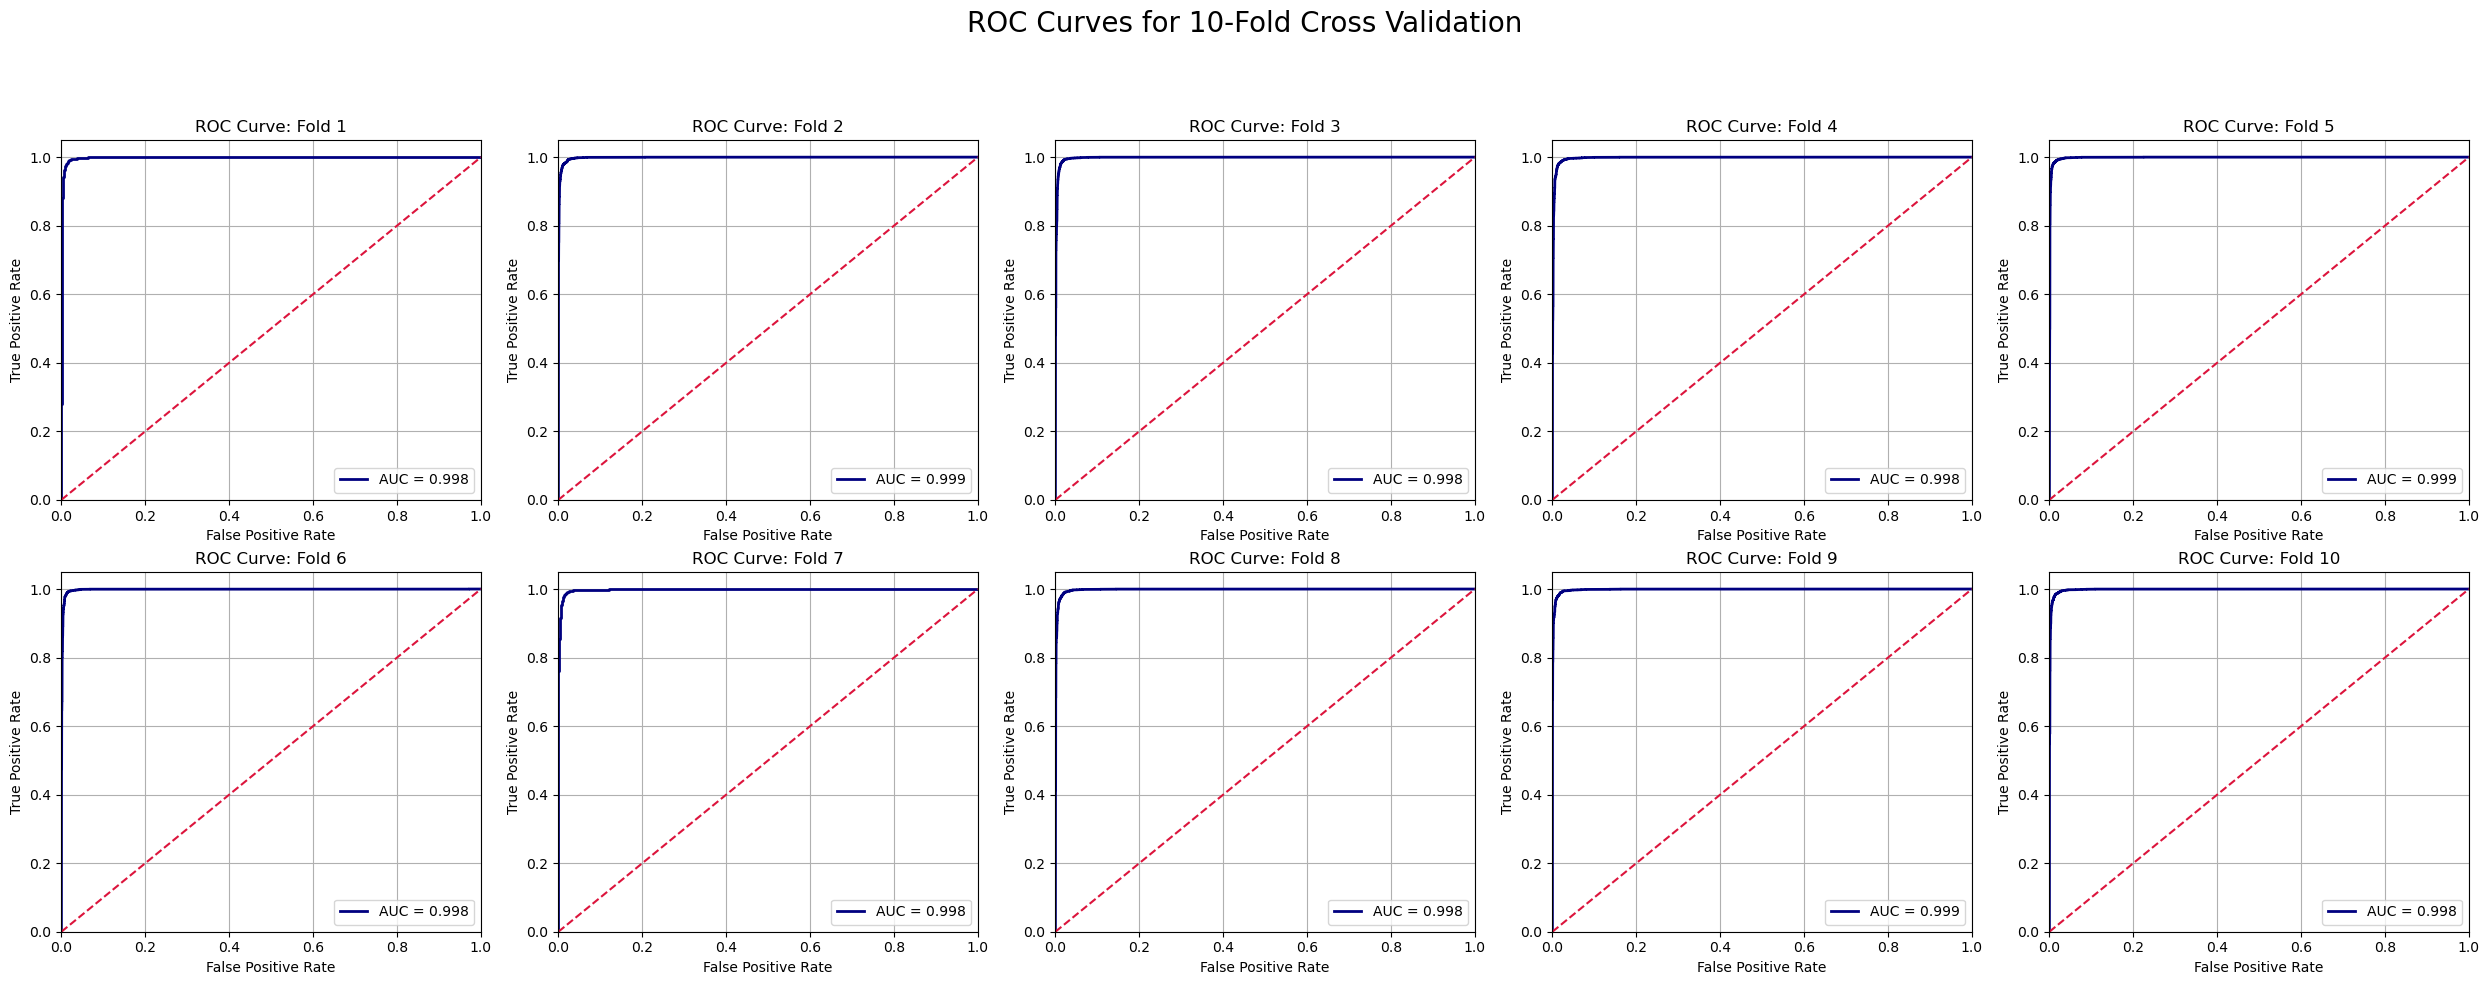


🏆 Best model found on Fold 2 with AUC = 0.9986


In [7]:


# Setup Stratified 10-Fold Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows and 5 columns
axs = axs.ravel()  # Flatten the 2D array of axes to 1D

best_auc = 0
best_model = None
best_fold = -1

fold = 0
for train_index, val_index in skf.split(tfidf_matrix, y):
    fold += 1
    print(f"\n🧪 Training fold {fold}/10")

    X_train, X_val = tfidf_matrix[train_index], tfidf_matrix[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    y_proba_val = model.predict_proba(X_val)[:, 1]

    print(f"\n📋 Classification Report for Fold {fold}:\n")
    print(classification_report(y_val, y_pred_val))

    fpr, tpr, _ = roc_curve(y_val, y_proba_val)
    roc_auc = auc(fpr, tpr)
    print(f"🔍 AUC for Fold {fold}: {roc_auc:.4f}")

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model = model
        best_fold = fold

    axs[fold-1].plot(fpr, tpr, color='navy', lw=2, label=f"AUC = {roc_auc:.3f}")
    axs[fold-1].plot([0, 1], [0, 1], color='crimson', linestyle='--')
    axs[fold-1].set_xlim([0.0, 1.0])
    axs[fold-1].set_ylim([0.0, 1.05])
    axs[fold-1].set_title(f"ROC Curve: Fold {fold}")
    axs[fold-1].set_xlabel("False Positive Rate")
    axs[fold-1].set_ylabel("True Positive Rate")
    axs[fold-1].legend(loc="lower right")
    axs[fold-1].grid(True)

plt.suptitle("ROC Curves for 10-Fold Cross Validation", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

print(f"\n🏆 Best model found on Fold {best_fold} with AUC = {best_auc:.4f}")


<div style="
    background: linear-gradient(to right, #f3e5f5, #e1bee7);
    border: 2px solid #7b1fa2;
    padding: 20px;
    border-radius: 10px;
    font-family: 'Segoe UI', sans-serif;
">

<h2 style="color:#6a1b9a; margin-top:0;">📊 Interpretation of Classification Report & ROC Curve</h2>

<p style="font-size:16px; color:#4a148c;">
Your spam detection model performed <b>exceptionally well</b> based on the metrics below! Let’s break down what each metric means and what your results tell us:
</p>

<h4 style="color:#4a148c;">🔍 Precision</h4>
<ul style="color:#4a148c; font-size:15px;">
  <li><b>Class 0 (Not Spam):</b> Precision = <b>0.97</b> → When the model predicts “Not Spam,” it is correct 97% of the time.</li>
  <li><b>Class 1 (Spam):</b> Precision = <b>0.99</b> → When the model predicts “Spam,” it is correct 99% of the time, showing very few false positives.</li>
</ul>

<h4 style="color:#4a148c;">🔎 Recall</h4>
<ul style="color:#4a148c; font-size:15px;">
  <li><b>Class 0 (Not Spam):</b> Recall = <b>1.00</b> → The model correctly identifies 100% of the legitimate emails.</li>
  <li><b>Class 1 (Spam):</b> Recall = <b>0.90</b> → The model identifies 90% of actual spam emails, missing 10% (false negatives).</li>
</ul>

<h4 style="color:#4a148c;">⭐ F1-Score</h4>
<p style="font-size:15px; color:#4a148c;">
The harmonic mean of precision and recall, giving a balanced measure:
</p>
<ul style="color:#4a148c; font-size:15px;">
  <li><b>Class 0:</b> 0.98 — excellent balance in identifying legitimate emails.</li>
  <li><b>Class 1:</b> 0.94 — very strong, though there is slight room for improvement in catching all spam.</li>
</ul>

<h4 style="color:#4a148c;">📊 Overall Accuracy</h4>
<p style="font-size:15px; color:#4a148c;">
The model correctly classified <b>97%</b> of all emails, indicating robust performance.
</p>

---

<h4 style="color:#6a1b9a;">⚠️ About the ROC Curve Shape</h4>
<p style="font-size:15px; color:#4a148c;">
You noted your ROC curve closely resembles a <b>90-degree triangle</b>, meaning it rises very steeply to near-perfect true positive rate before moving along the top — this typically indicates <b>excellent discriminative ability</b>.</p>

<p style="font-size:15px; color:#4a148c;">
However, if the curve forms an almost perfect right angle right at the start, it might also hint at <b>overfitting</b> or a model that is very confident in its predictions but may not generalize well to unseen data. It's worth validating with cross-validation or additional datasets.
</p>

---

💡 <b>Summary:</b> Your model is very accurate and precise at spotting both spam and non-spam emails, with a slight drop in recall for spam — meaning some spam emails slip through undetected. The ROC shape confirms strong classification power but warrants monitoring for overfitting.

---

✨ Next steps could include hyperparameter tuning, testing on more data, or experimenting with ensemble models for even better recall on spam.

</div>


## testing on a whole other dataset

<div style="
    background: linear-gradient(to right, #fffef9, #fefcf7);
    border: 2px solid #f0d9b5;
    padding: 20px;
    border-radius: 15px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    color: #7a5c3e;
">

<h2 style="color:#a67c33; margin-top:0;">🔍 Testing Our Model on a Completely New Dataset </h2>

<p style="font-size:16px; line-height:1.5;">
After training and validating our spam detection model on one dataset, it's essential to test it on a <strong>completely unseen dataset</strong>. Here's why:
</p>

<ul style="font-size:16px; color:#8b6e4a;">
  <li>🧪 <strong>Assess Generalization:</strong>  
      Testing on new data verifies if the model can accurately predict emails it has <em>never</em> seen before, simulating real-world usage.</li>
  
  <li>📊 <strong>Prevent Overfitting:</strong>  
      A model may perform excellently on training data but fail on new data if it has memorized patterns instead of learning true spam indicators.</li>
  
  <li>🌍 <strong>Robustness to Variations:</strong>  
      New datasets may differ in word distribution, email styles, or spam tactics; testing ensures the model remains effective despite these differences.</li>
  
  <li>🧠 <strong>Validate Model Improvements:</strong>  
      When experimenting with new features or algorithms, the unseen dataset serves as a reliable benchmark for genuine progress.</li>
  
  <li>🔐 <strong>Confidence for Deployment:</strong>  
      Before deploying your spam filter in production, testing on fresh data builds trust that it will handle real incoming emails well.</li>
</ul>

<p style="font-size:16px;">
In summary, testing on a new dataset confirms your model is <strong>trustworthy, reliable, and effective in real-world scenarios</strong>. This is a crucial step from research to impact!
</p>

</div>


In [ ]:
test_df = pd.DataFrame(pd.read_csv("./data/test/emails.csv"))
test_df.head()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')  
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')


lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
punctuation = list(string.punctuation)
combined_stop = stop_words + punctuation + ["subject", "fwd", "re"]

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # verb
    elif treebank_tag.startswith('N'):
        return 'n'  # noun
    elif treebank_tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default noun

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in combined_stop]  
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return lemmatized

test_df['tokens_lemmatized'] = test_df['text'].apply(lemmatize_text)



# test lr_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_dat

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.80      0.88      3900
           1       0.70      0.94      0.80      1896

    accuracy                           0.85      5796
   macro avg       0.83      0.87      0.84      5796
weighted avg       0.88      0.85      0.85      5796



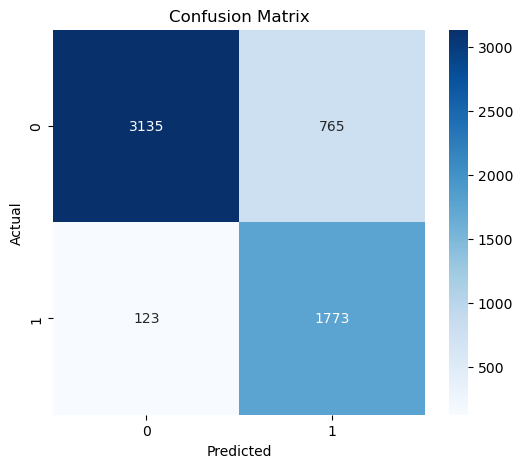

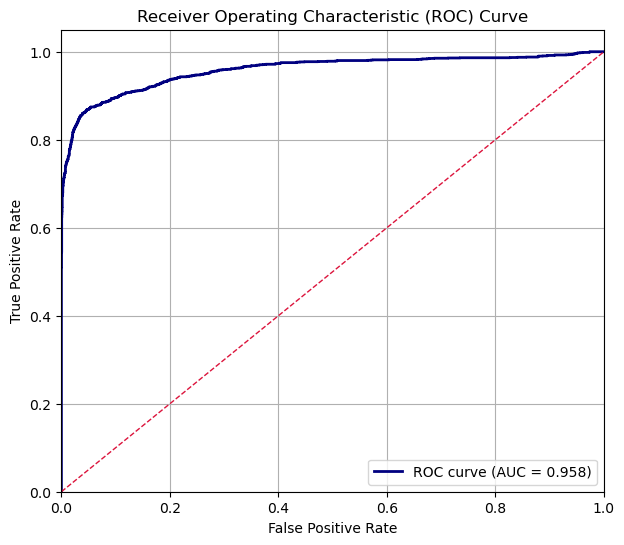

In [ ]:

X_test = test_df["tokens_lemmatized"].apply(lambda x: " ".join(x))
y_test = test_df["target"]

new_tfidf_matrix = vectorizer.transform(X_test)

y_test_pred = best_model.predict(new_tfidf_matrix)
y_test_pob = best_model.predict_proba(new_tfidf_matrix)[:, 1] 
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

fpr, tpr, thresholds = roc_curve(y_test, y_test_pob) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='crimson', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
X_test = test_df["tokens_lemmatized"].apply(lambda x: " ".join(x))
y_test = test_df["target"]

new_tfidf_matrix = vectorizer.transform(X_test)

y_test_pred = best_rf_model.predict(new_tfidf_matrix)
y_test_prob = best_rf_model.predict_proba(new_tfidf_matrix)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='crimson', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.77      0.85      3900
           1       0.66      0.94      0.78      1896

    accuracy                           0.82      5796
   macro avg       0.81      0.86      0.82      5796
weighted avg       0.87      0.82      0.83      5796



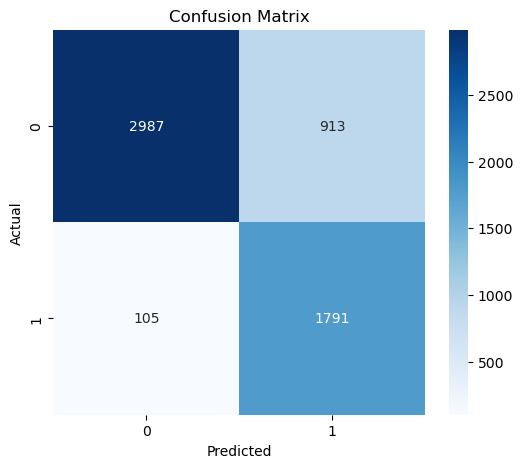

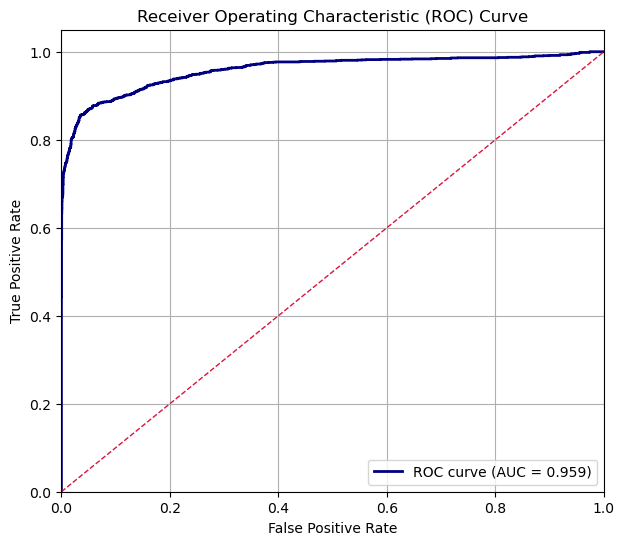

In [13]:

X_test = test_df["tokens_lemmatized"].apply(lambda x: " ".join(x))
y_test = test_df["target"]

new_tfidf_matrix = vectorizer.transform(X_test)

y_test_pred = best_model.predict(new_tfidf_matrix)
y_test_pob = best_model.predict_proba(new_tfidf_matrix)[:, 1]  # Probability estimates for positive class

print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

fpr, tpr, thresholds = roc_curve(y_test, y_test_pob) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='crimson', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


<div style="
    background: linear-gradient(to right, #e1f5fe, #ede7f6);
    border: 2px solid #64b5f6;
    padding: 20px;
    border-radius: 12px;
    font-family: 'Segoe UI', sans-serif;
    color: #1a237e;
">

<h2 style="color:#1976d2; margin-top:0;">📈 Updated Model Evaluation on Unseen Dataset</h2>

<p style="font-size:16px;">
This evaluation reflects the performance of the <b>Logistic Regression spam classifier</b> on an unseen dataset with improved results.
</p>

---

### 🧪 <u>Classification Report Summary:</u>

<table style="width:100%; font-size:16px; color:#333; border-collapse: collapse;">
  <thead>
    <tr style="background-color:#bbdefb;">
      <th align="left">Label</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
      <th>Support</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Ham (0)</b></td>
      <td>0.96 ✅</td>
      <td>0.80</td>
      <td>0.88 ✅</td>
      <td>3900</td>
    </tr>
    <tr>
      <td><b>Spam (1)</b></td>
      <td>0.70 ✅</td>
      <td>0.94 ✅</td>
      <td>0.80 ✅</td>
      <td>1896</td>
    </tr>
    <tr style="background-color:#c8e6c9;">
      <td><b>Overall</b></td>
      <td colspan="4">
        🎯 <b>Accuracy:</b> <span style="color:#1976d2;">85.0%</span><br>
        📊 <b>Macro Avg F1-Score:</b> 0.84 ✅<br>
        🧠 <b>Weighted Avg F1-Score:</b> 0.85 ✅<br>
        📈 <b>ROC AUC:</b> ~0.96
      </td>
    </tr>
  </tbody>
</table>

---

### 💡 <u>Interpretation</u>:

- ✅ **Improved Accuracy**: The model now achieves an **85% accuracy**, outperforming previous runs.
- 🔍 **Spam Detection (class 1)**:
  - ✅ **High Recall = 0.94**: Excellent at identifying almost all spam.
  - ✅ **Improved Precision = 0.70**: Fewer ham messages are misclassified as spam.
- 💌 **Ham Detection (class 0)**:
  - ✅ **High Precision = 0.96** ensures most "ham" predictions are correct.
  - ⚠️ **Recall = 0.80**: Still some missed ham messages.
- 📊 **Macro & Weighted F1-scores improved**: Indicates **more balanced performance** across both classes.

---

### 🌈 <u>Conclusion</u>:
This version of the classifier shows strong improvements in both spam and ham detection. With higher precision and recall, it's becoming more reliable. Future improvements might include:
- Further fine-tuning hyperparameters,
- Exploring regularization techniques,
- Or testing ensemble methods like Random Forest or Gradient Boosting for robustness.

</div>


### saving model for later call

In [16]:
feature_names = vectorizer.get_feature_names_out()
coefs = best_model.coef_[0]

model_filename = "lr_model.joblib"
vectorizer_filename = "tfidf_vectorizer.joblib"
features_filename = "feature_names.txt"

os.makedirs("./models", exist_ok=True)

joblib.dump(best_model, "./models/" + model_filename)
joblib.dump(vectorizer, "./models/" + vectorizer_filename)

with open(f"./data/{features_filename}", "w", encoding="utf-8") as f:
    for feat in feature_names:
        f.write(feat + "\n")


### import later

In [17]:
from joblib import load

best_model = load("./models/lr_model.joblib")
vectorizer = load("./models/tfidf_vectorizer.joblib")

# Use them to predict on new data
new_text = ["free money now", "meeting rescheduled"]
new_tfidf = vectorizer.transform(new_text)
predictions = model.predict(new_tfidf)
predictions


array([1, 1], dtype=int64)